In [45]:
#we need add here a lot of comments

In [1]:
# Comment: Import everything we need for this test notebook.
import os
import pickle
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from data_loading.gather_mat_files_multiple import gather_mat_files_multiple_condition
from data_loading.load_intervals import load_intervals_data
from data_loading.load_scores import load_scores_data
from data_loading.load_postprocessed import load_postprocessed_data

from distance_calculation.approach1_multi_hot import approach1_multi_hot_distance
from distance_calculation.approach5_simple_euclidean import approach5_simple_euclidean_distance
from distance_calculation.approach2_intervals import approach2_interval_distance
from distance_calculation.approach3_markov import approach3_markov_distance
from distance_calculation.approach4_scores import approach4_scores_distance

# Comment: Define the base folder that contains your multiple-condition subfolders.
base_folder = r"D:\behavior_ethogram_project_Ilya"

In [3]:
# 2) Gather .mat files for all conditions found under the base_folder
all_condition_files, condition_names = gather_mat_files_multiple_condition([base_folder])


# 3) Load postprocessed (binary) data for each condition/behavior combination.
all_flies_post, post_index_map, post_cond_names = load_postprocessed_data(
    all_condition_files,
    single=False,
    condition_names=condition_names
)
# 4) Load continuous scores data.
all_flies_scores, scores_index_map, scores_cond_names = load_scores_data(
    all_condition_files,
    single=False,
    condition_names=condition_names
)

# 5: Load interval data
all_flies_intervals, intervals_index_map, intervals_cond_names = load_intervals_data(
    all_condition_files,
    single=False,
    condition_names=condition_names
)

In [4]:

# 5) Capture behavior names by parsing filenames for each condition
behavior_names_per_condition = []
for cond_files in all_condition_files:
    # cond_files is a list of .mat filepaths for a single condition
    names_for_this_cond = []
    for filepath in cond_files:
        base = os.path.basename(filepath)            # e.g. "scores_Grooming.mat"
        no_ext = os.path.splitext(base)[0]           # e.g. "scores_Grooming"
        # behavior name is everything after first underscore, or if multiple underscores, up to user logic
        # example: "scores_Grooming" => "Grooming"
        parts = no_ext.split("_", 1)  # split once on first '_'
        if len(parts) == 2:
            behavior_name = parts[1]  # e.g. "Grooming"
        else:
            behavior_name = no_ext   # fallback if unexpected format
        names_for_this_cond.append(behavior_name)
    behavior_names_per_condition.append(names_for_this_cond)
    #creating dict
    export_data = {
    "postprocessed_data": all_flies_post,        # global list of postprocessed (T,B) arrays
    "index_map": post_index_map,
    "condition_names": post_cond_names,
    "behavior_names_per_condition": behavior_names_per_condition
}

In [5]:
# Comment: Create experiment datasets for each condition
exp_females_grouped = export_data['postprocessed_data'][0]
exp_females_singles = export_data['postprocessed_data'][1]
exp_males_grouped = export_data['postprocessed_data'][2]
exp_males_single = export_data['postprocessed_data'][3]

In [50]:
print(exp_females_grouped)
print(behavior_names_per_condition)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['Grooming', 'Jump', 'Long_Distance_Approach', 'Long_Lasting_Interaction', 'Short_Distance_Approach', 'Social_Clustering', 'Stable_Interaction', 'Stop', 'Touch', 'Turn', 'Walk'], ['Grooming', 'Jump', 'Long_Distance_Approach', 'Long_Lasting_Interaction', 'Short_Distance_Approach', 'Social_Clustering', 'Stable_Interaction', 'Stop', 'Touch', 'Turn', 'Walk'], ['Grooming', 'Jump', 'Long_Distance_Approach', 'Long_Lasting_Interaction', 'Short_Distance_Approach', 'Social_Clustering', 'Stable_Interaction', 'Stop', 'Touch', 'Turn', 'Walk'], ['Grooming', 'Jump', 'Long_Distance_Approach', 'Long_Lasting_Interaction', 'Short_Distance_Approach', 'Social_Clustering', 'Stable_Interaction', 'Stop', 'Touch', 'Turn', 'Walk']]


In [6]:
# Map flies to their correct condition
dfs_females_grouped = [
    pd.DataFrame(all_flies_post[global_fly_idx], columns=behavior_names_per_condition[condition_idx])
    for global_fly_idx, (condition_idx, local_fly_idx) in post_index_map.items()
    if condition_idx == 0  # 0 corresponds to 'Assa_Females_Grouped'
]

dfs_females_singles = [
    pd.DataFrame(all_flies_post[global_fly_idx], columns=behavior_names_per_condition[condition_idx])
    for global_fly_idx, (condition_idx, local_fly_idx) in post_index_map.items()
    if condition_idx == 1  # 1 corresponds to 'Assa_Females_Singles'
]

dfs_males_grouped = [
    pd.DataFrame(all_flies_post[global_fly_idx], columns=behavior_names_per_condition[condition_idx])
    for global_fly_idx, (condition_idx, local_fly_idx) in post_index_map.items()
    if condition_idx == 2  # 2 corresponds to 'Assa_Males_Grouped'
]

dfs_males_single = [
    pd.DataFrame(all_flies_post[global_fly_idx], columns=behavior_names_per_condition[condition_idx])
    for global_fly_idx, (condition_idx, local_fly_idx) in post_index_map.items()
    if condition_idx == 3  # 3 corresponds to 'Assa_Males_Single'
]


<Axes: >

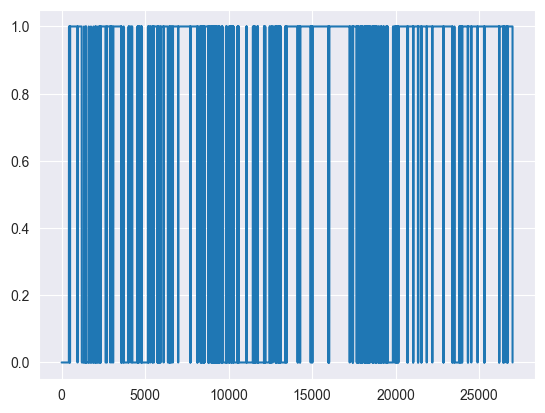

In [52]:
dfs_females_grouped[0]['Grooming'].plot()

In [53]:
# Function to create DataFrames for each condition
def create_experiment_data(condition_idx):
    return [
        pd.DataFrame(all_flies_post[global_fly_idx], columns=behavior_names_per_condition[condition_idx])
        for global_fly_idx, (cond_idx, local_fly_idx) in post_index_map.items()
        if cond_idx == condition_idx
    ]

In [35]:
import matplotlib.ticker as ticker
import matplotlib as mpl

def process_and_plot(exp_data, title):
    exp_sum = pd.DataFrame(np.sum(exp_data, axis=0), columns=behavior_names_per_condition[0]).rename_axis('time')
    exp_sum.index = exp_sum.index / 30  # Convert frames to seconds

    num_behaviors = exp_sum.shape[1]  # Actual number of behaviors
    num_cols = 3
    num_rows = int(np.ceil(num_behaviors / num_cols))  # Adjust rows dynamically

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10), sharex=True)
    axes = axes.flatten()  # Flatten to easily index

    # Use Matplotlib's default color cycle
    prop_cycle = mpl.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']  # Get default colors

    for i, col in enumerate(exp_sum.columns):
        ax = axes[i]
        exp_sum[col].plot(ax=ax, title=col, color=colors[i % len(colors)])  # Cycle through default colors

        # Dynamically adjust x-axis ticks to show minutes correctly
        max_time = exp_sum.index.max()
        tick_positions = np.linspace(0, max_time, num=4)  # 0, 5, 10, 15 min
        tick_labels = [f"{int(x/60)}" for x in tick_positions]  # Convert seconds to minutes

        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels)
        ax.set_xlabel("Minutes")

        ax.grid()

    # Hide any extra empty subplots
    for j in range(num_behaviors, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

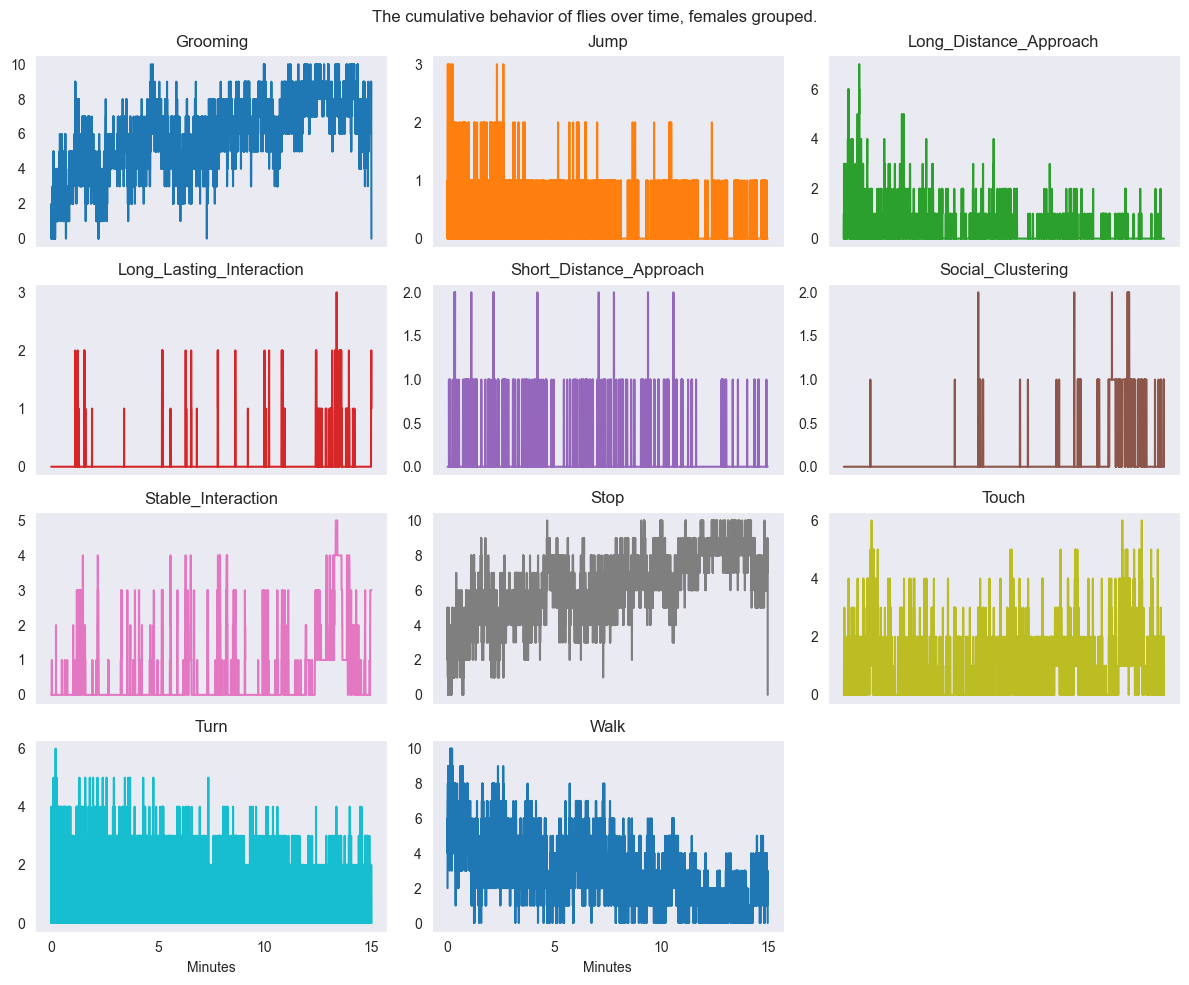

In [55]:
# Plot for experiment 1
process_and_plot(dfs_females_grouped, 'The cumulative behavior of flies over time, females grouped.')

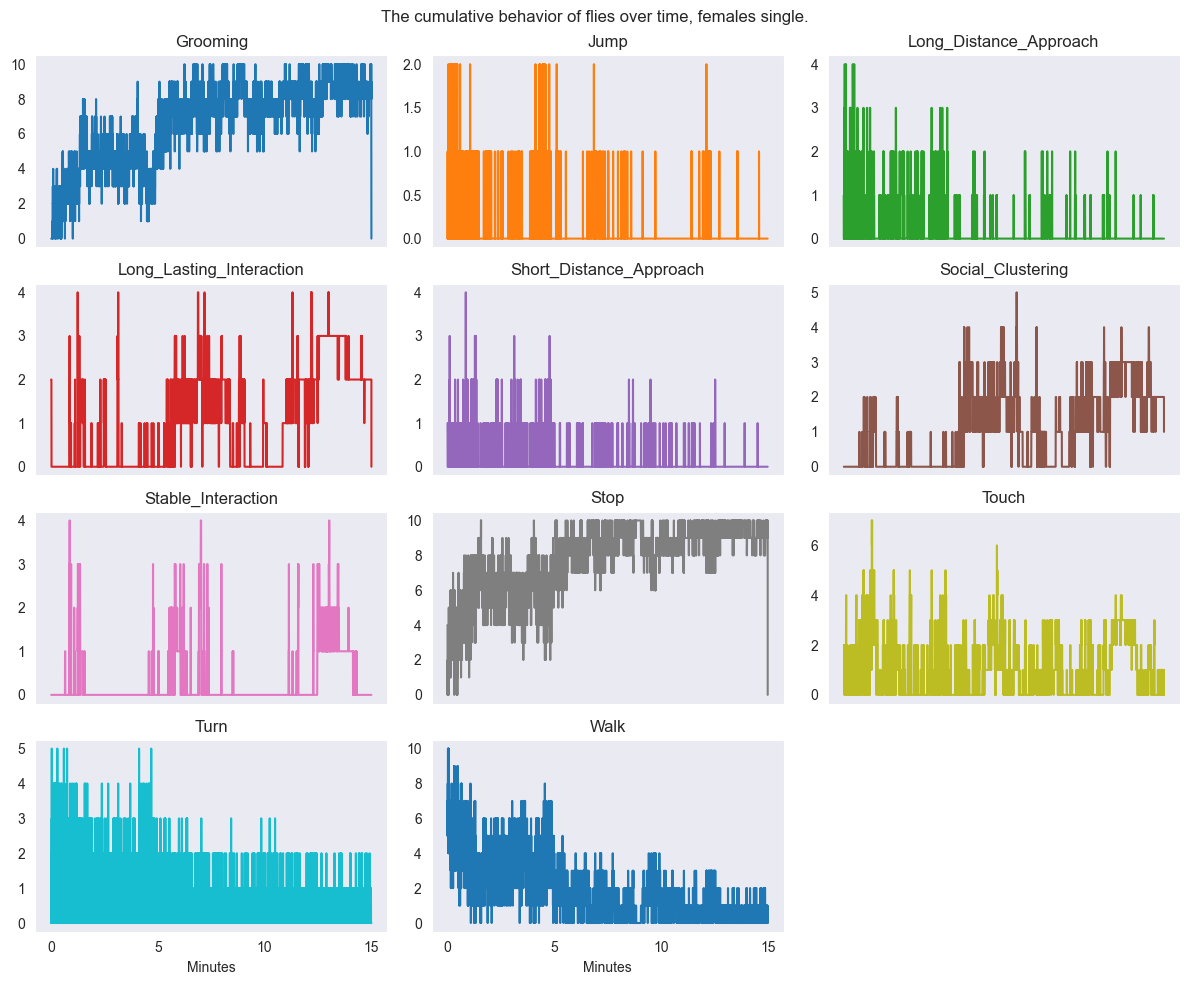

In [56]:
# Plot for experiment 2
process_and_plot(dfs_females_singles, 'The cumulative behavior of flies over time, females single.')


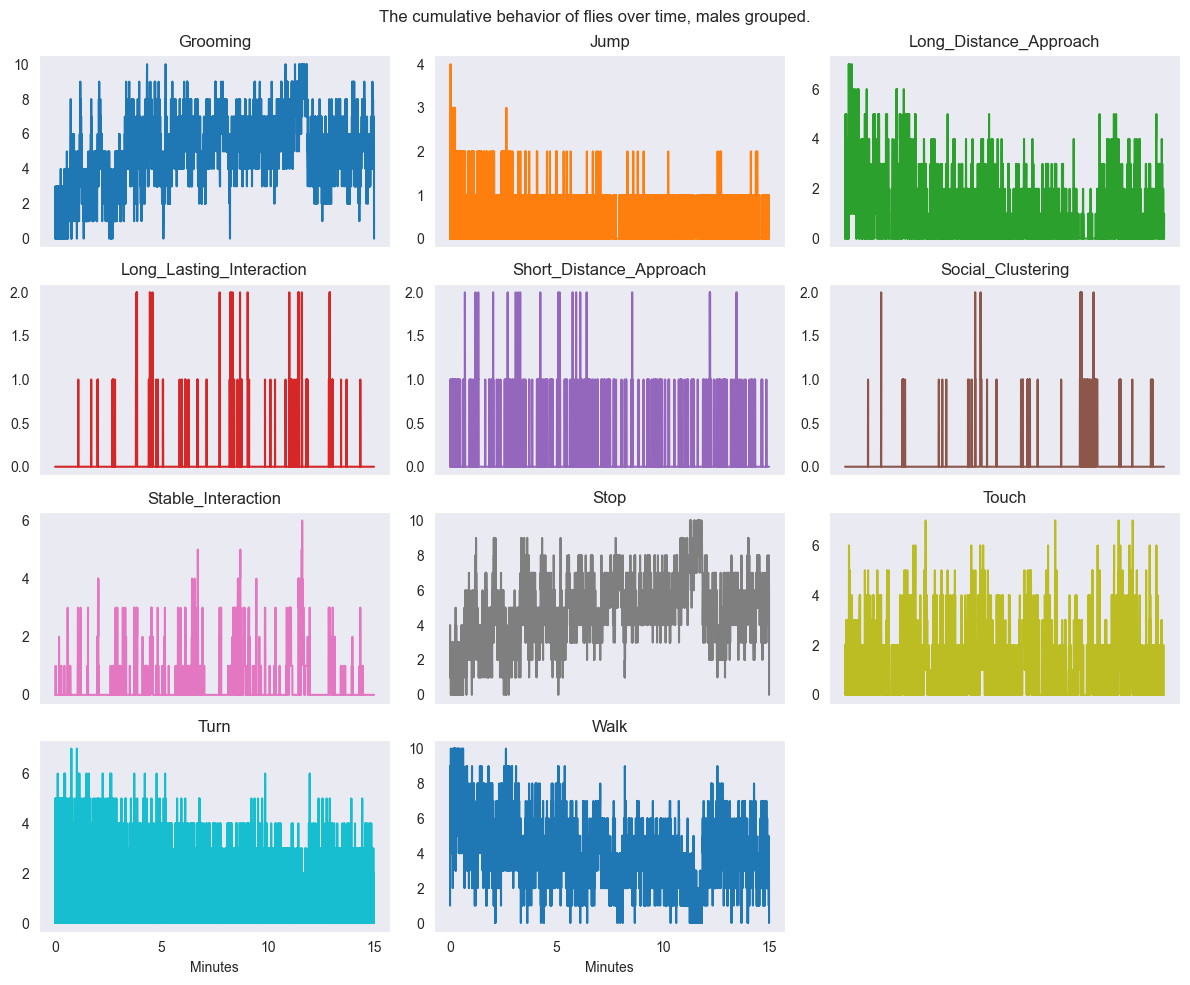

In [57]:

# Plot for experiment 3
process_and_plot(dfs_males_grouped, 'The cumulative behavior of flies over time, males grouped.')


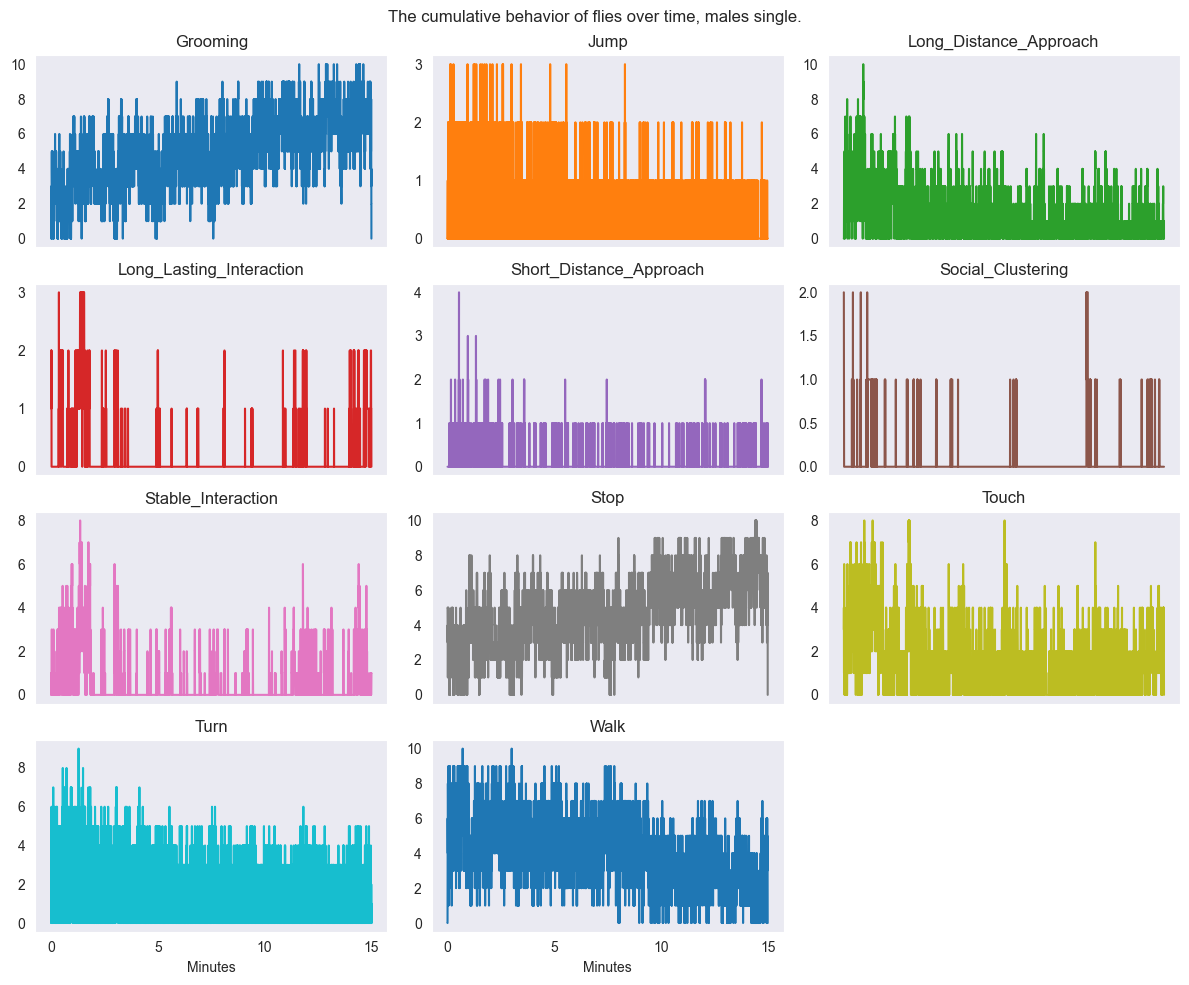

In [58]:

# Plot for experiment 4
process_and_plot(dfs_males_single, 'The cumulative behavior of flies over time, males single.')


In [40]:
def process_and_plot_grooming(exp_data, title):
    exp_sum = pd.DataFrame(np.sum(exp_data, axis=0), columns=behavior_names_per_condition[0]).rename_axis('time')
    exp_sum.index = exp_sum.index / 30  # Convert frames to seconds
    exp_grooming = exp_sum[['Grooming']]

    ax = exp_grooming.plot(figsize=(10, 6), title=title)

    # Correcting x-axis labels
    max_time = exp_grooming.index.max()
    tick_positions = np.linspace(0, max_time, num=4)  # 0, 5, 10, 15 min
    tick_labels = [f"{int(x/60)}" for x in tick_positions]  # Convert seconds to minutes

    plt.xticks(tick_positions, tick_labels)
    plt.xlabel("Time (minutes)")
    plt.ylabel("Cumulative Grooming Behavior")
    plt.grid()
    plt.show()


<Figure size 1200x800 with 0 Axes>

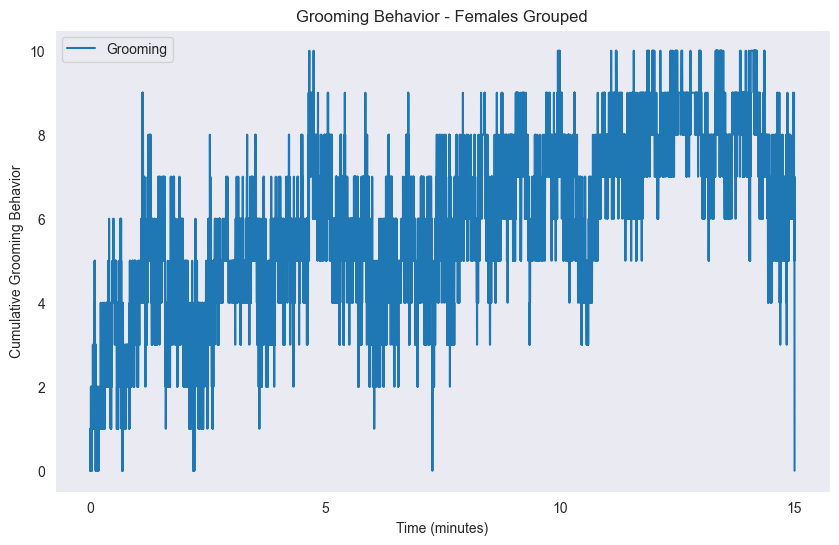

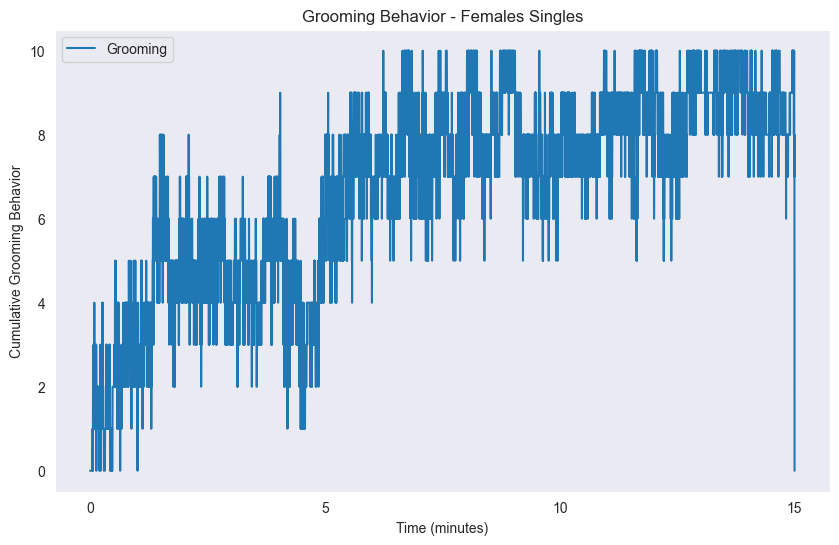

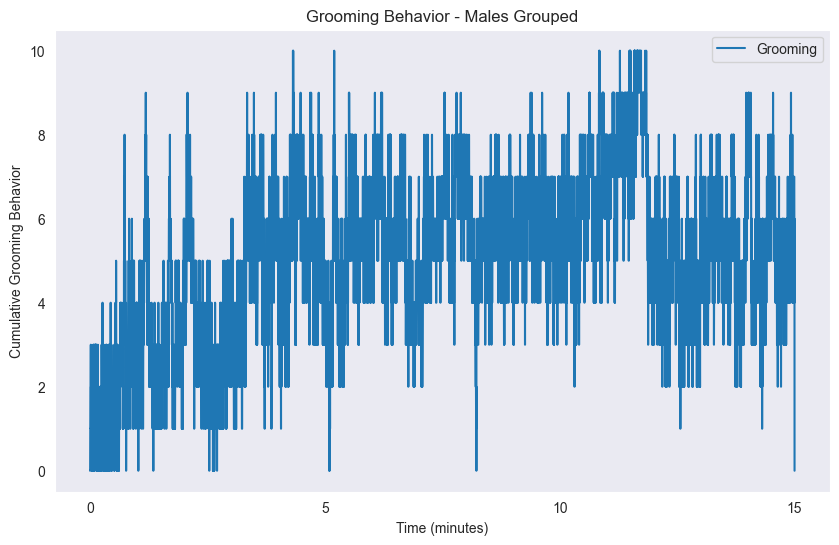

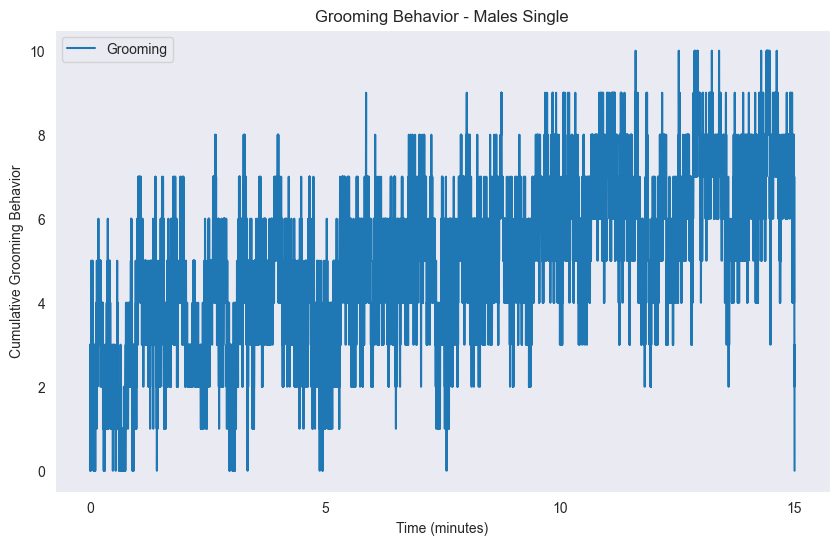

In [41]:
plt.figure(figsize=(12, 8))

process_and_plot_grooming(dfs_females_grouped, 'Grooming Behavior - Females Grouped')
process_and_plot_grooming(dfs_females_singles, 'Grooming Behavior - Females Singles')
process_and_plot_grooming(dfs_males_grouped, 'Grooming Behavior - Males Grouped')
process_and_plot_grooming(dfs_males_single, 'Grooming Behavior - Males Single')

plt.show()


In [62]:
#Distance analysis

In [63]:
all_exps_arrays = [
    [df.to_numpy() for df in dfs_females_grouped],
    [df.to_numpy() for df in dfs_females_singles],
    [df.to_numpy() for df in dfs_males_grouped],
    [df.to_numpy() for df in dfs_males_single]
]


In [7]:
# Normalization helper
def normalize_distances(dist_list):
    arr = np.array(dist_list)
    if len(arr) == 0:
        return arr
    mn, mx = arr.min(), arr.max()
    if mx == mn:
        return arr
    return (arr - mn) / (mx - mn)

def compute_intra_inter_distances(all_exps, distance_func,
                                  n_pairs_intra=50, n_pairs_inter=50,
                                  trim_arrays=True):
    """
    all_exps : list of lists of data for each experiment, each sublist containing data for flies.
    distance_func : function that takes two flies' data arrays and returns a float distance.
    n_pairs_intra, n_pairs_inter : how many random comparisons to do in each category.
    trim_arrays : whether to trim arrays to matching length before distance (True for postprocessed/scores).
    """
    intra_dists = []
    inter_dists = []

    def trim_to_min_length(arr1, arr2):
        min_length = min(arr1.shape[0], arr2.shape[0])
        return arr1[:min_length], arr2[:min_length]

    # Intra-group distances
    for _ in range(n_pairs_intra):
        exp_idx = random.randint(0, len(all_exps) - 1)
        flies = all_exps[exp_idx]
        if len(flies) < 2:
            continue
        flyA, flyB = random.sample(flies, 2)
        if trim_arrays:
            flyA, flyB = trim_to_min_length(flyA, flyB)
        dist_val = distance_func(flyA, flyB)
        intra_dists.append(dist_val)

    # Inter-group distances
    for _ in range(n_pairs_inter):
        exp1, exp2 = random.sample(range(len(all_exps)), 2)
        if not all_exps[exp1] or not all_exps[exp2]:
            continue
        flyA = random.choice(all_exps[exp1])
        flyB = random.choice(all_exps[exp2])
        if trim_arrays:
            flyA, flyB = trim_to_min_length(flyA, flyB)
        dist_val = distance_func(flyA, flyB)
        inter_dists.append(dist_val)

    # Compute means (normalized)
    intra_mean = normalize_distances(intra_dists).mean() if len(intra_dists) > 0 else np.nan
    inter_mean = normalize_distances(inter_dists).mean() if len(inter_dists) > 0 else np.nan
    ratio = intra_mean / inter_mean if (inter_mean and inter_mean != 0) else np.inf

    return intra_mean, inter_mean, ratio

In [8]:
# Ensure each fly's intervals are extracted correctly
dfs_intervals_females_grouped = [
    all_flies_intervals[global_fly_idx]  # Already a list of dictionaries
    for global_fly_idx, (condition_idx, _) in intervals_index_map.items()
    if condition_idx == 0 and len(all_flies_intervals[global_fly_idx]) > 0
]

dfs_intervals_females_singles = [
    all_flies_intervals[global_fly_idx]
    for global_fly_idx, (condition_idx, _) in intervals_index_map.items()
    if condition_idx == 1 and len(all_flies_intervals[global_fly_idx]) > 0
]

dfs_intervals_males_grouped = [
    all_flies_intervals[global_fly_idx]
    for global_fly_idx, (condition_idx, _) in intervals_index_map.items()
    if condition_idx == 2 and len(all_flies_intervals[global_fly_idx]) > 0
]

dfs_intervals_males_single = [
    all_flies_intervals[global_fly_idx]
    for global_fly_idx, (condition_idx, _) in intervals_index_map.items()
    if condition_idx == 3 and len(all_flies_intervals[global_fly_idx]) > 0
]
# Ensure `interval_datasets` is structured correctly for compute_intra_inter_distances()
interval_datasets = [
    [fly_intervals for fly_intervals in cond_data if len(fly_intervals) > 0]  # Ensure non-empty lists
    for cond_data in [
        dfs_intervals_females_grouped, dfs_intervals_females_singles,
        dfs_intervals_males_grouped, dfs_intervals_males_single
    ]
]


In [9]:
# Map flies to their correct condition using scores data
dfs_scores_females_grouped = [
    pd.DataFrame(all_flies_scores[global_fly_idx])
    for global_fly_idx, (condition_idx, local_fly_idx) in scores_index_map.items()
    if condition_idx == 0  # 0 corresponds to 'Assa_Females_Grouped'
]

dfs_scores_females_singles = [
    pd.DataFrame(all_flies_scores[global_fly_idx])
    for global_fly_idx, (condition_idx, local_fly_idx) in scores_index_map.items()
    if condition_idx == 1  # 1 corresponds to 'Assa_Females_Singles'
]

dfs_scores_males_grouped = [
    pd.DataFrame(all_flies_scores[global_fly_idx])
    for global_fly_idx, (condition_idx, local_fly_idx) in scores_index_map.items()
    if condition_idx == 2  # 2 corresponds to 'Assa_Males_Grouped'
]

dfs_scores_males_single = [
    pd.DataFrame(all_flies_scores[global_fly_idx])
    for global_fly_idx, (condition_idx, local_fly_idx) in scores_index_map.items()
    if condition_idx == 3  # 3 corresponds to 'Assa_Males_Single'
]
# Convert scores DataFrames to NumPy arrays (like postprocessed data)
scores_datasets = [
    [df.to_numpy() for df in cond_data]
    for cond_data in [
        dfs_scores_females_grouped, dfs_scores_females_singles,
        dfs_scores_males_grouped, dfs_scores_males_single
    ]
]



In [11]:
# Compute intra-group and inter-group distances for Interval approach
if interval_datasets and all(len(exp) > 1 for exp in interval_datasets):
    intra_a2, inter_a2, ratio_a2 = compute_intra_inter_distances(
        interval_datasets, approach2_interval_distance,
        n_pairs_intra=10, n_pairs_inter=10,
        trim_arrays=False  # Intervals do not require trimming
    )
else:
    intra_a2, inter_a2, ratio_a2 = np.nan, np.nan, np.nan

# Store results in DataFrame
results2 = pd.DataFrame({
    'Method': ['Approach2_Intervals'],
    'Avg Intra-Group': [intra_a2],
    'Avg Inter-Group': [inter_a2],
    'Ratio (Intra/Inter)': [ratio_a2]
})

print(results2)


                Method  Avg Intra-Group  Avg Inter-Group  Ratio (Intra/Inter)
0  Approach2_Intervals         0.563904         0.344147             1.638556


In [15]:
# Convert postprocessed DataFrames to NumPy arrays (T, B)
postprocessed_datasets = [
    [df.to_numpy() for df in cond_data]
    for cond_data in [dfs_females_grouped, dfs_females_singles, dfs_males_grouped, dfs_males_single]
]

# Compute intra-group and inter-group distances for Hamming approach
if postprocessed_datasets:
    intra_a1, inter_a1, ratio_a1 = compute_intra_inter_distances(
        postprocessed_datasets, approach1_multi_hot_distance,
        n_pairs_intra=20, n_pairs_inter=20,
        trim_arrays=True  # No trimming needed for multi-hot data
    )
else:
    intra_a1, inter_a1, ratio_a1 = np.nan, np.nan, np.nan

# Store results in DataFrame
results1 = pd.DataFrame({
    'Method': ['Approach1_Hamming'],
    'Avg Intra-Group': [intra_a1],
    'Avg Inter-Group': [inter_a1],
    'Ratio (Intra/Inter)': [ratio_a1]
})

print(results1)


              Method  Avg Intra-Group  Avg Inter-Group  Ratio (Intra/Inter)
0  Approach1_Hamming         0.604757         0.363269             1.664766


In [17]:
# Compute intra-group and inter-group distances for Euclidean approach
if postprocessed_datasets:
    intra_a5, inter_a5, ratio_a5 = compute_intra_inter_distances(
        postprocessed_datasets, approach5_simple_euclidean_distance,
        n_pairs_intra=20, n_pairs_inter=20,
        trim_arrays=True  # No trimming needed for Euclidean distance
    )
else:
    intra_a5, inter_a5, ratio_a5 = np.nan, np.nan, np.nan

# Store results in DataFrame
results5 = pd.DataFrame({
    'Method': ['Approach5_Euclidean'],
    'Avg Intra-Group': [intra_a5],
    'Avg Inter-Group': [inter_a5],
    'Ratio (Intra/Inter)': [ratio_a5]
})

print(results5)


                Method  Avg Intra-Group  Avg Inter-Group  Ratio (Intra/Inter)
0  Approach5_Euclidean         0.618767         0.520383              1.18906


In [23]:
# Reduce number of comparisons to minimize computation time and avoid convergence issues
if scores_datasets and all(len(exp) > 1 for exp in scores_datasets):
    intra_a3, inter_a3, ratio_a3 = compute_intra_inter_distances(
        scores_datasets, approach3_markov_distance,
        n_pairs_intra=3,  # Reduced
        n_pairs_inter=3,  # Reduced (too small to really say something)
        trim_arrays=True  # Trim sequences for Markov modeling
    )
else:
    intra_a3, inter_a3, ratio_a3 = np.nan, np.nan, np.nan

# Store results in DataFrame
results3 = pd.DataFrame({
    'Method': ['Approach3_HMM'],
    'Avg Intra-Group': [intra_a3],
    'Avg Inter-Group': [inter_a3],
    'Ratio (Intra/Inter)': [ratio_a3]
})

print(results3)


Model is not converging.  Current: 172373.27957062618 is not greater than 172373.3519008754. Delta is -0.0723302492115181


          Method  Avg Intra-Group  Avg Inter-Group  Ratio (Intra/Inter)
0  Approach3_HMM     127262.92531     40776.811111             3.120963


In [19]:
# Compute intra-group and inter-group distances for Approach 4 (DTW)
if scores_datasets:
    intra_a4, inter_a4, ratio_a4 = compute_intra_inter_distances(
        scores_datasets, approach4_scores_distance,
        n_pairs_intra=6, n_pairs_inter=6,
        trim_arrays=True  # DTW benefits from trimming to equal lengths
    )
else:
    intra_a4, inter_a4, ratio_a4 = np.nan, np.nan, np.nan

# Store results in DataFrame
results4 = pd.DataFrame({
    'Method': ['Approach4_DTW'],
    'Avg Intra-Group': [intra_a4],
    'Avg Inter-Group': [inter_a4],
    'Ratio (Intra/Inter)': [ratio_a4]
})

print(results4)


          Method  Avg Intra-Group  Avg Inter-Group  Ratio (Intra/Inter)
0  Approach4_DTW         0.502366         0.488844              1.02766


In [24]:
all_results = pd.concat([results1, results2, results3, results4, results5], ignore_index=True)
print(all_results)

                Method  Avg Intra-Group  Avg Inter-Group  Ratio (Intra/Inter)
0    Approach1_Hamming         0.604757         0.363269             1.664766
1  Approach2_Intervals         0.563904         0.344147             1.638556
2        Approach3_HMM    127262.925310     40776.811111             3.120963
3        Approach4_DTW         0.502366         0.488844             1.027660
4  Approach5_Euclidean         0.618767         0.520383             1.189060


In [28]:
### **Helper Function to Trim Arrays to the Same Length**
def trim_to_min_length(arr1, arr2):
    min_length = min(arr1.shape[0], arr2.shape[0])
    return arr1[:min_length], arr2[:min_length]

### **Step 1: Select 5 Flies from Female Singles and 5 from Male Grouped**
# Use postprocessed data for Hamming & Euclidean, scores for DTW
selected_flies_postprocessed = (
    [df.to_numpy() for df in dfs_females_singles[:5] if not df.empty] +
    [df.to_numpy() for df in dfs_males_grouped[:5] if not df.empty]
)
selected_flies_scores = (
    [df.to_numpy() for df in dfs_scores_females_singles[:5] if not df.empty] +
    [df.to_numpy() for df in dfs_scores_males_grouped[:5] if not df.empty]
)

# Ensure we only proceed if at least 10 flies exist in both datasets
n_flies = min(len(selected_flies_postprocessed), len(selected_flies_scores))

# Trim both datasets to ensure they match in fly count
selected_flies_postprocessed = selected_flies_postprocessed[:n_flies]
selected_flies_scores = selected_flies_scores[:n_flies]

### **Step 2: Initialize Distance Matrices**
dist_matrix_ap4 = np.zeros((n_flies, n_flies))  # DTW (Scores)
dist_matrix_ap5 = np.zeros((n_flies, n_flies))  # Euclidean (Postprocessed)
dist_matrix_ap1 = np.zeros((n_flies, n_flies))  # Hamming (Postprocessed)

### **Step 3: Compute Pairwise Distances**
for i in range(n_flies):
    for j in range(i + 1, n_flies):  # Compute only upper triangle to avoid redundant calculations
        # Trim arrays to the same length if needed
        trimmed_scores_i, trimmed_scores_j = trim_to_min_length(selected_flies_scores[i], selected_flies_scores[j])
        trimmed_post_i, trimmed_post_j = trim_to_min_length(selected_flies_postprocessed[i], selected_flies_postprocessed[j])

        # Compute distances
        dist_ap4 = approach4_scores_distance(trimmed_scores_i, trimmed_scores_j)  # DTW (Scores)
        dist_ap5 = approach5_simple_euclidean_distance(trimmed_post_i, trimmed_post_j)  # Euclidean
        dist_ap1 = approach1_multi_hot_distance(trimmed_post_i, trimmed_post_j)  # Hamming

        # Store distances symmetrically
        dist_matrix_ap4[i, j] = dist_matrix_ap4[j, i] = dist_ap4
        dist_matrix_ap5[i, j] = dist_matrix_ap5[j, i] = dist_ap5
        dist_matrix_ap1[i, j] = dist_matrix_ap1[j, i] = dist_ap1

### **Step 4: Convert to DataFrames for Display**
df_ap4 = pd.DataFrame(dist_matrix_ap4, columns=[f"Fly_{i}" for i in range(n_flies)], index=[f"Fly_{i}" for i in range(n_flies)])
df_ap5 = pd.DataFrame(dist_matrix_ap5, columns=[f"Fly_{i}" for i in range(n_flies)], index=[f"Fly_{i}" for i in range(n_flies)])
df_ap1 = pd.DataFrame(dist_matrix_ap1, columns=[f"Fly_{i}" for i in range(n_flies)], index=[f"Fly_{i}" for i in range(n_flies)])

### **Step 5: Print Distance Matrices**
print("\nApproach 4 (DTW) Distance Matrix:\n", df_ap4)
print("\nApproach 5 (Euclidean) Distance Matrix:\n", df_ap5)
print("\nApproach 1 (Hamming) Distance Matrix:\n", df_ap1)


Approach 4 (DTW) Distance Matrix:
               Fly_0         Fly_1         Fly_2         Fly_3         Fly_4  \
Fly_0      0.000000  48455.149053  32677.837164  40382.329838  31602.811475   
Fly_1  48455.149053      0.000000  46051.037903  50393.351680  46286.420547   
Fly_2  32677.837164  46051.037903      0.000000  39058.289438  30610.762493   
Fly_3  40382.329838  50393.351680  39058.289438      0.000000  39994.037505   
Fly_4  31602.811475  46286.420547  30610.762493  39994.037505      0.000000   
Fly_5  48611.724829  58126.254482  48557.807196  44126.271420  50558.101534   
Fly_6  43737.723614  57363.256528  45029.089531  43545.465976  46983.047845   
Fly_7  43086.861518  51295.031752  43079.492924  45218.201194  43701.343799   
Fly_8  44259.193980  55539.268254  47163.301227  47012.124753  45650.260188   
Fly_9  47143.381091  57388.302828  48287.651760  46883.440987  47885.936755   

              Fly_5         Fly_6         Fly_7         Fly_8         Fly_9  
Fly_0  48611.724

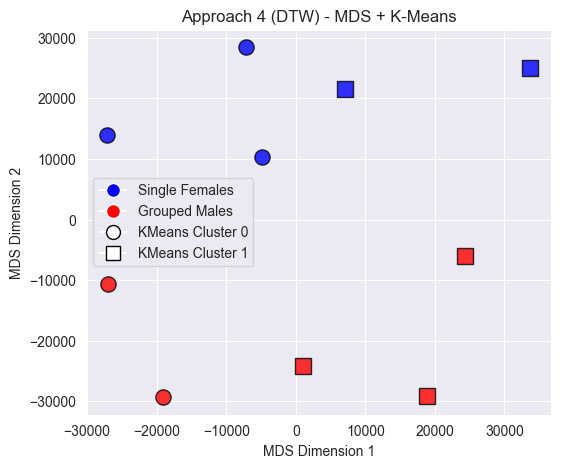

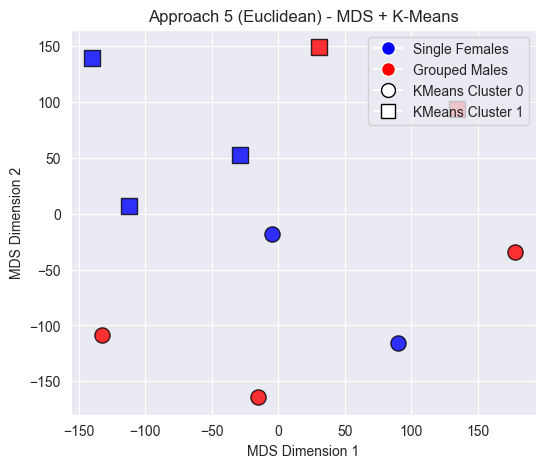

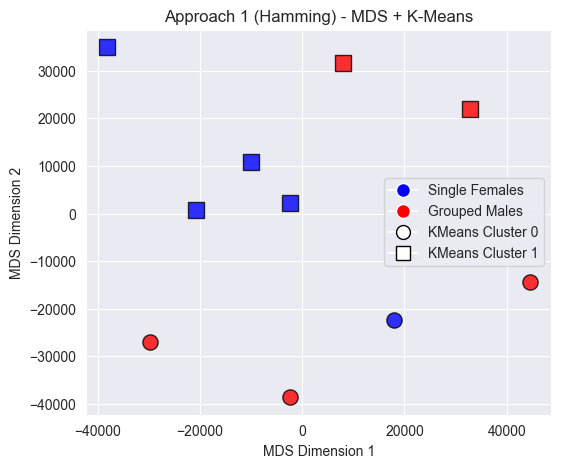

In [31]:
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

def plot_mds_kmeans(df_distance, title="MDS + K-Means Clusters"):
    """
    df_distance: a 10×10 distance matrix (pandas DataFrame) with rows/cols = Fly_0..Fly_9
    title: Plot title
    """
    # Convert distance matrix to a NumPy array
    dist_matrix = df_distance.values

    # MDS to project into 2D
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    coords_2d = mds.fit_transform(dist_matrix)  # shape (10,2)

    # K-Means clustering on the 2D coords
    kmeans = KMeans(n_clusters=2, random_state=42)
    cluster_labels = kmeans.fit_predict(coords_2d)  # array of 0/1

    # Color mapping based on real groups:
    # First 5 (Fly_0–Fly_4) = Single Female Group (Blue)
    # Last 5 (Fly_5–Fly_9) = Grouped Male Group (Red)
    color_map = ['blue'] * 5 + ['red'] * 5
    label_map = ['Single Females'] * 5 + ['Grouped Males'] * 5  # Text labels for legend

    # Map cluster label to marker shape: cluster 0 -> circle, cluster 1 -> square
    shape_map = ['o' if lbl == 0 else 's' for lbl in cluster_labels]

    # Create plot
    plt.figure(figsize=(6, 5))
    for i in range(len(df_distance)):
        x, y = coords_2d[i]
        plt.scatter(
            x, y,
            color=color_map[i],
            marker=shape_map[i],
            s=120,
            edgecolor='black',
            alpha=0.8
        )

    # Create a custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label="Single Females"),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label="Grouped Males"),
        Line2D([0], [0], marker='o', color='w', markeredgecolor='black', markersize=10, label="KMeans Cluster 0"),
        Line2D([0], [0], marker='s', color='w', markeredgecolor='black', markersize=10, label="KMeans Cluster 1")
    ]

    plt.legend(handles=legend_elements, loc="best")
    plt.title(title)
    plt.xlabel("MDS Dimension 1")
    plt.ylabel("MDS Dimension 2")
    plt.grid(True)
    plt.show()


plot_mds_kmeans(df_ap4, title="Approach 4 (DTW) - MDS + K-Means")
plot_mds_kmeans(df_ap5, title="Approach 5 (Euclidean) - MDS + K-Means")
plot_mds_kmeans(df_ap1, title="Approach 1 (Hamming) - MDS + K-Means")


#Clustering

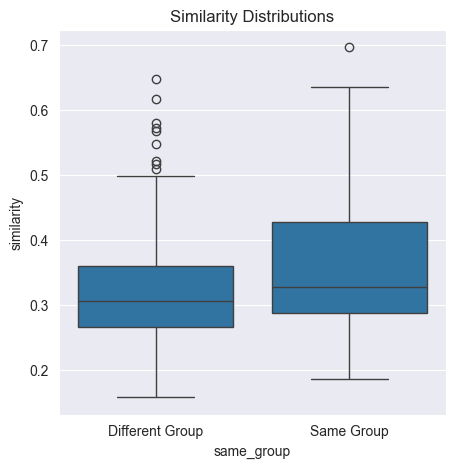

In [50]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

all_experiments = [
    dfs_females_grouped,
    dfs_females_singles,
    dfs_males_grouped,
    dfs_males_single
]

# Find the global minimum behavior dimension across all flies
all_arrays_flat = [df.to_numpy() for group_data in all_experiments for df in group_data if not df.empty]
global_min_behaviors = min(arr.shape[1] for arr in all_arrays_flat) if all_arrays_flat else 0

# Convert DataFrames to numpy arrays while ensuring equal shape along behavior axis
all_exps_arrays = []
for group_data in all_experiments:
    arrays_for_this_group = [df.to_numpy()[:, :global_min_behaviors] for df in group_data if not df.empty]
    all_exps_arrays.append(arrays_for_this_group)

def compute_simple_similarity(flyA, flyB):
    """
    Compute correlation as a simple similarity measure.
    Ensure both flies have the same flattened size by trimming to the shortest time series.
    """
    # Ensure the time (T) dimension matches
    min_time = min(flyA.shape[0], flyB.shape[0])
    flyA, flyB = flyA[:min_time], flyB[:min_time]  # Trim to shortest time

    vecA = flyA.flatten()
    vecB = flyB.flatten()

    if np.std(vecA) == 0 or np.std(vecB) == 0:
        return 0  # Avoid NaN issues

    return np.corrcoef(vecA, vecB)[0, 1]


### Compute Similarities
random.seed(42)
n_pairs = 200  # Number of random pairs to sample
similarities = []
labels = []  # 1 for same group, 0 for different

num_groups = len(all_exps_arrays)

# Intra-group similarity (flies from the same condition)
for _ in range(n_pairs):
    g = random.randint(0, num_groups - 1)
    if len(all_exps_arrays[g]) < 2:
        continue
    flyA, flyB = random.sample(all_exps_arrays[g], 2)
    sim = compute_simple_similarity(flyA, flyB)
    similarities.append(sim)
    labels.append(1)  # Same group

# Inter-group similarity (flies from different conditions)
for _ in range(n_pairs):
    gA, gB = random.sample(range(num_groups), 2)
    if not all_exps_arrays[gA] or not all_exps_arrays[gB]:
        continue
    flyA = random.choice(all_exps_arrays[gA])
    flyB = random.choice(all_exps_arrays[gB])
    sim = compute_simple_similarity(flyA, flyB)
    similarities.append(sim)
    labels.append(0)  # Different group

### Visualization
df = pd.DataFrame({
    'similarity': similarities,
    'same_group': labels
})

plt.figure(figsize=(5, 5))
sns.boxplot(data=df, x='same_group', y='similarity')
plt.xticks([0, 1], ['Different Group', 'Same Group'])
plt.title('Similarity Distributions')
plt.show()


Text(0.5, 0.65, 'Logit(p) = 2.0023 * similarity + -0.6888')

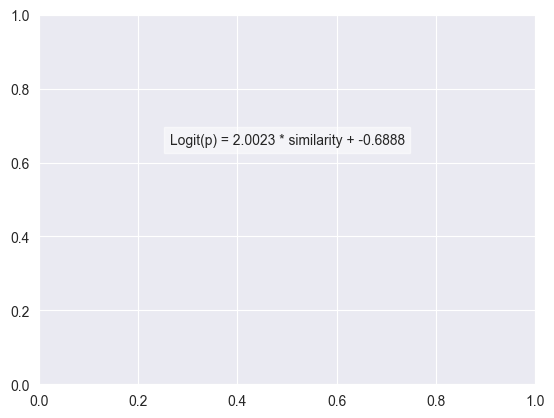

In [51]:
### Logistic Regression (No Plotting)
X = df[['similarity']].values
y = df['same_group'].values

model = LogisticRegression()
model.fit(X, y)
coef = model.coef_[0][0]  # Extract coefficient
intercept = model.intercept_[0]  # Extract intercept
equation = f"Logit(p) = {coef:.4f} * similarity + {intercept:.4f}"

plt.text(0.5, 0.65, equation, fontsize=10, ha='center', bbox=dict(facecolor='white', alpha=0.5))
